In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
pd.options.mode.chained_assignment = None

# Data Preparation and EDA

In [2]:
cc_info = pd.read_csv('cc_info.csv')
transactions = pd.read_csv('transactions.csv')
transactions['date'] = pd.to_datetime(transactions['date'])

**Get geographic location for where the credit card is registered, if the postal code is invalid, the coordinates would be replaced by the cities'.**

In [3]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="your_app_name")

def get_long_lat(x):
    
    try:
        address = x['city']+' '+x['state']+' '+x['zipcode']
        location = geolocator.geocode(address, country_codes='us')[1]
    except:
        address = x['city']+' '+x['state']
        location = geolocator.geocode(address, country_codes='us')[1]

    return location

In [4]:
cc_info.zipcode = cc_info.zipcode.astype(str)
cc_info.zipcode = cc_info.zipcode.apply(lambda x: '0'+x if len(x)==4 else x)

cc_info['register_long'] = cc_info.apply(lambda x: get_long_lat(x)[1], axis=1)
cc_info['register_lat'] = cc_info.apply(lambda x: get_long_lat(x)[0], axis=1)

**Combine two data sets.**

In [5]:
df = transactions.merge(cc_info, how='left', on='credit_card')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 294588 entries, 0 to 294587
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   credit_card                294588 non-null  int64         
 1   date                       294588 non-null  datetime64[ns]
 2   transaction_dollar_amount  294588 non-null  float64       
 3   Long                       294588 non-null  float64       
 4   Lat                        294588 non-null  float64       
 5   city                       294588 non-null  object        
 6   state                      294588 non-null  object        
 7   zipcode                    294588 non-null  object        
 8   credit_card_limit          294588 non-null  int64         
 9   register_long              294588 non-null  float64       
 10  register_lat               294588 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(2), object(3

**Users who never went up the limit**

In [7]:
df['month'] = df['date'].apply(lambda x: x.month)

In [8]:
df_month = df.groupby(['credit_card', 'month', 'credit_card_limit'], as_index=False).agg({"transaction_dollar_amount": sum})
df_month['over_limit'] = df_month.apply(lambda x: 1 if x['transaction_dollar_amount']>x['credit_card_limit'] else 0, axis=1)

In [9]:
df_month_agg = df_month.groupby('credit_card', as_index=False).agg({"over_limit": sum})
df_month_agg[df_month_agg.over_limit==0]

,credit_card,over_limit
0,1003715054175576,0
1,1013870087888817,0
2,1023820165155391,0
3,1073931538936472,0
4,1077622576192810,0
...,...,...
978,9946917923319410,0
979,9958678964376192,0
980,9961694231875562,0
981,9981251982982618,0


**Over limit notification**

In [10]:
transactions['transaction_date'] = transactions['date'].apply(lambda x: x.date().strftime("%Y-%m-%d"))

In [11]:
from collections import defaultdict

class notification():
    
    def __init__(self, date=str):
        
        month_beginning = date[:-2]+'01'
        self.card_limit = cc_info.set_index('credit_card')['credit_card_limit'].to_dict()
        self.total_spend = defaultdict(float)
        self.monthly_transactions = transactions[(transactions.transaction_date >= month_beginning)&(transactions.transaction_date <= date)]

        
    def cum_sum(self):
        
        all_users = self.monthly_transactions['credit_card'].unique()
        for i in all_users:
            amount = self.monthly_transactions[self.monthly_transactions.credit_card==i]['transaction_dollar_amount'].sum()
            self.total_spend[i] += amount
        
        user_list = [k for k, v in self.total_spend.items() if v > self.card_limit[k]]
        
        return print("List of users who have gone up the credit limit: \n", user_list)
        

In [12]:
warning = notification('2015-09-15')

**Given the day '2015-09-15', there were 2 people went over their limit on that day**

In [13]:
warning.cum_sum()

List of users who have gone up the credit limit: 
 [3281814060807145, 6984795534098127]


# Detect the unusuals

## Feature engineering

**Intuitively, if a transaction happened in a place that was very different from where the card was registered, it might be a fraud. In addition, the hour of a transaction could be suspicious as well, for instance, transactions that often took place in some odd timing might be frauds. Therefore, features to capture this are created**

In [14]:
from geopy.distance import distance

In [15]:
def get_distance(x):
    
    try:
        d = distance([x['Lat'], x['Long']], [x['register_lat'], x['register_long']]).km
    except:
        d = 1000
        
    return d

In [16]:
df['distance'] = df.apply(lambda x: get_distance(x), axis=1)

In [17]:
df['hour'] = df['date'].apply(lambda x: x.hour)
df['weekday'] = df['date'].apply(lambda x: x.weekday())

**Another import aspect is the transaction amount and frequency, because ones purchasing behaviour is unlike to change in a short period of time.** 

In [18]:
df_amount = df.groupby(['credit_card'], as_index=False).agg({"transaction_dollar_amount": [lambda x: x.describe()['mean'],
                                                                           lambda x: x.describe(percentiles=[0.75])['75%'],
                                                                           lambda x: x.describe(percentiles=[0.95])['95%']]})

df_amount.columns = ['credit_card', 'amount_mean', 'amount_75%', 'amount_95%']

In [19]:
df = df.merge(df_amount, how='left', on='credit_card')

In [20]:
df_modeling = df[['credit_card','transaction_dollar_amount','credit_card_limit','distance','amount_mean','amount_75%',
                  'amount_95%','hour','weekday']]

In [21]:
df_modeling.head()

,credit_card,transaction_dollar_amount,credit_card_limit,distance,amount_mean,amount_75%,amount_95%,hour,weekday
0,1003715054175576,43.78,20000,3.933044,110.497471,124.63,176.14,0,4
1,1003715054175576,103.15,20000,7.511141,110.497471,124.63,176.14,22,5
2,1003715054175576,48.55,20000,7.389253,110.497471,124.63,176.14,18,0
3,1003715054175576,136.18,20000,5.866592,110.497471,124.63,176.14,19,3
4,1003715054175576,71.82,20000,9.153604,110.497471,124.63,176.14,20,0


**There are many features (dimensions) in the dataset that might be correlated however, they might carry information that should not be ignored. One solution would be reduced the dimension without losing too much information, PCA is a great method achieving this task.**

In [22]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [23]:
X = df_modeling.loc[:,df_modeling.columns != 'credit_card']

In [24]:
X.head()

,transaction_dollar_amount,credit_card_limit,distance,amount_mean,amount_75%,amount_95%,hour,weekday
0,43.78,20000,3.933044,110.497471,124.63,176.14,0,4
1,103.15,20000,7.511141,110.497471,124.63,176.14,22,5
2,48.55,20000,7.389253,110.497471,124.63,176.14,18,0
3,136.18,20000,5.866592,110.497471,124.63,176.14,19,3
4,71.82,20000,9.153604,110.497471,124.63,176.14,20,0


**Before implementing the algorithm, it is crucial to scale the data to eliminate the effect of numeric magnitude.**

In [25]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [26]:
pca = PCA()
X_reduced = pca.fit_transform(X)

In [27]:
explained_variance_ratio = pca.explained_variance_ratio_
explained_variance_ratio

array([0.44238318, 0.13433307, 0.12501935, 0.11568622, 0.11198151,
       0.06105599, 0.00786573, 0.00167495])

**Based on the output of the PCA algorithm, the dataset could be well reprensted by 4 components, therefore, we can reduce the dimensions of the data from 8 to 4.**

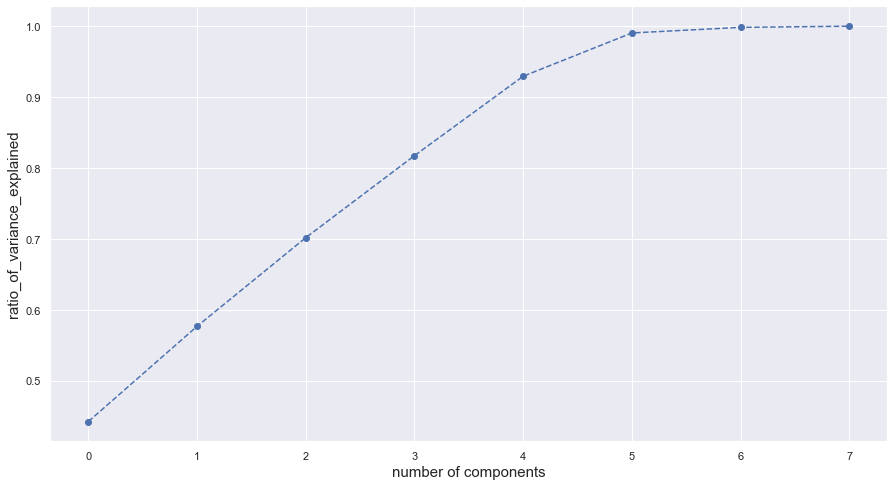

In [28]:
plt.figure(figsize=(15, 8))
plt.plot(range(len(explained_variance_ratio)), explained_variance_ratio.cumsum(), marker='o', linestyle='--')
plt.ylabel("ratio_of_variance_explained", fontsize=15)
plt.xlabel("number of components", fontsize=15);

In [29]:
pca = PCA(n_components=4)
X_reduced = pca.fit_transform(X)

**We can therefore cluster the data using K Means.**

In [30]:
elbow = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=123)
    kmeans.fit(X_reduced)
    elbow.append(kmeans.inertia_)


**Using the "Elbow" method, the optimal clusters for this data is 5.**

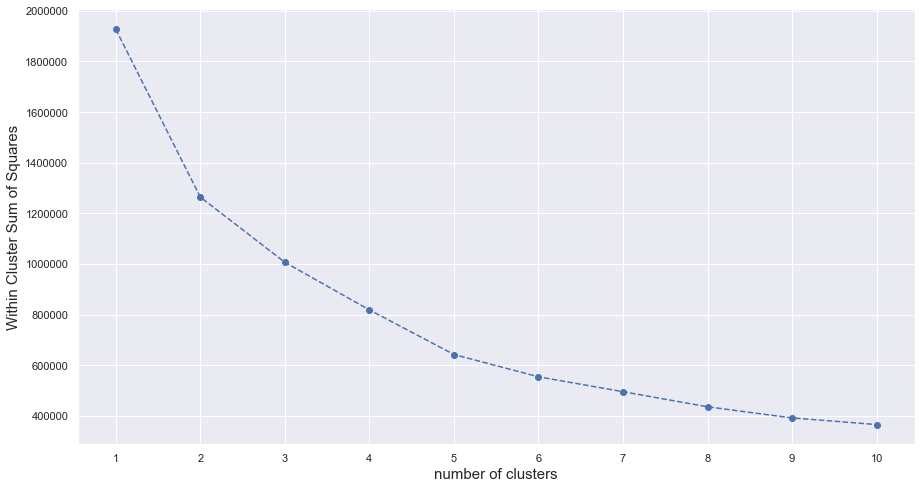

In [31]:
plt.figure(figsize=(15, 8))
plt.plot(range(1, len(elbow)+1), elbow, marker='o', linestyle='--')
plt.xticks(range(1, len(elbow)+1))
plt.xlabel("number of clusters", fontsize=15)
plt.ylabel("Within Cluster Sum of Squares", fontsize=15);

In [32]:
kmeans = KMeans(n_clusters=5, random_state=123).fit(X_reduced)

In [33]:
df_modeling['label'] = kmeans.labels_
df_modeling['label'] = df_modeling['label'].astype(str)

**Counts for the number of each label.**

In [34]:
df_modeling['label'].value_counts()

3    106783
0    101058
1     42835
4     39834
2      4078
Name: label, dtype: int64

In [43]:
df_modeling[df_modeling.label=='2'].head(10)

,credit_card,transaction_dollar_amount,credit_card_limit,distance,amount_mean,amount_75%,amount_95%,hour,weekday,label
8,1003715054175576,95.20,20000,6648.246747,110.497471,124.63,176.14,19,3,2
14,1003715054175576,146.75,20000,12118.945860,110.497471,124.63,176.14,21,4,2
113,1003715054175576,99.27,20000,10151.473501,110.497471,124.63,176.14,16,1,2
128,1003715054175576,87.77,20000,19105.258827,110.497471,124.63,176.14,0,6,2
141,1003715054175576,53.31,20000,9436.010604,110.497471,124.63,176.14,20,4,2
259,1003715054175576,103.11,20000,7425.327956,110.497471,124.63,176.14,23,3,2
306,1013870087888817,40.52,15000,9429.057295,107.961525,128.02,189.51,0,1,2
484,1013870087888817,66.33,15000,11039.578747,107.961525,128.02,189.51,17,4,2
495,1013870087888817,109.28,15000,6267.963446,107.961525,128.02,189.51,18,3,2
512,1013870087888817,72.65,15000,11320.060323,107.961525,128.02,189.51,19,5,2


**According to the algorithm, the cluster that is labled 2 have unique attributes that separate themselves from the rest. Looking closely at this cluster, they are driven by the distance, namely, the distance is a strong factor for division, other factors, such as transaction_dollar_amount does have as strong effect as the distance that has cluster built around it.**

**A three dimensional plot based on distance, hour and transaction_dollar_amount gives the idea of how they are clustered, however, without further due, the transactions that happend in a place far from where the credit is registered should raise the red flag.**

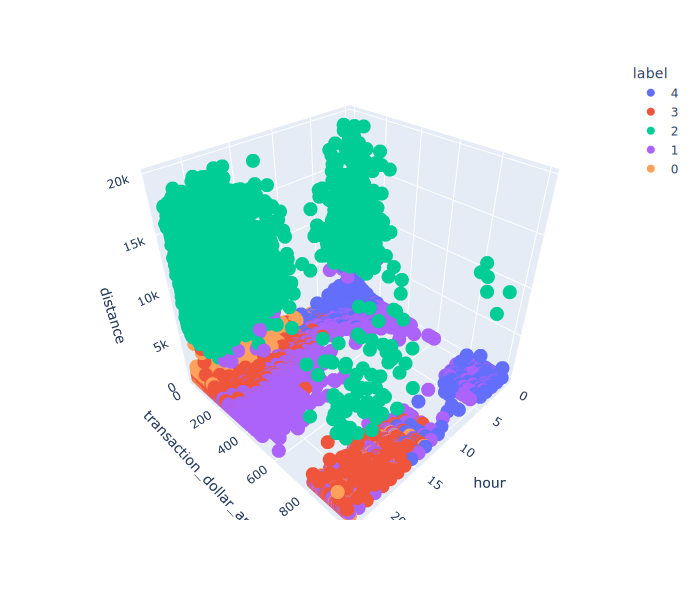

In [36]:
import plotly.express as px
import plotly.io as pio
pio.renderers
fig = px.scatter_3d(df_modeling, x='hour', y='transaction_dollar_amount', z='distance',color='label', height=600)
fig.show(renderer="svg")